In [38]:
# Загружаем необходимые нам библиотеки
import pandas as pd
import numpy as np

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time

# для нормализации, стандартизации
from sklearn import preprocessing

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Загружаем тесты для отбра признаков
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova

# Импортируем необходимые библиотеки:
import category_encoders as ce # для кодирования признаков
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Загружаем и объединняем данные

In [39]:
# загружаем данные из соревнования
df_train = pd.read_csv('data/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('data/submission.csv') # самбмишн

In [38]:
# для корректной обработки признаков объединяем train и test в единый dataframe
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тестовых данных отсутствует признак reviewer_score. Значения этого признака мы его должны предсказать. Временно заполняем признак нулями

hotels = df_test.append(df_train, sort=False).reset_index(drop=True)

In [39]:
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0


In [40]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Из информации полученной о данных можно сказать о наличии пропусков в признаках lat (широта отеля) и lng (долгота отеля). Запомним это для дальнейшей работы с данными.

### Работа с пропусками

In [41]:
# для удобства заполнения пропусков в признаках lat и lng извлечём признаки страны и города из признака hotel_address  
hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: 'United Kingdom' if x.split()[-1]=='Kingdom' else x.split()[-1])
hotels['hotel_city'] = hotels['hotel_address'].apply(lambda x: x.split()[-5] if x.split()[-1]=='Kingdom' else x.split()[-2])

In [42]:
# Получим список уникальных городов, в которых содержатся пропуски координат отелей
lat_mask = hotels['lat'].isnull()
lng_mask = hotels['lng'].isnull()

null_city = list(set(hotels[lat_mask]['hotel_city']))

display(f'Количество уникальных значений городов, для которых обнаружены пропуски: {len(null_city)}')
print(null_city)

'Количество уникальных значений городов, для которых обнаружены пропуски: 3'

['Vienna', 'Barcelona', 'Paris']


In [43]:
# после обработки признак hotel_address можно удалить
hotels.drop('hotel_address', axis=1, inplace=True)

In [44]:
list(lat_mask.index) == list(lng_mask.index) # если в строке пропущена одна координата, то в этой же строке пропущена вторая

True

In [45]:
# создадим словарь с модальными значениями координат по каждому городу с пропусками в данных
lat_dict = {}
lng_dict = {}

for city in null_city:
    lat_dict[city] = lat_dict.get(city, hotels[hotels['hotel_city']==city]['lat'].mode()[0])
    lng_dict[city] = lng_dict.get(city, hotels[hotels['hotel_city']==city]['lng'].mode()[0])

In [46]:
# заполняем пропуски в lat и lng модальными значениями для конкретного города
for city in null_city:
    hotels.loc[(lat_mask & (hotels['hotel_city'] == city)), 'lat'] = lat_dict[city]
    hotels.loc[(lng_mask & (hotels['hotel_city'] == city)), 'lng'] = lng_dict[city]

In [47]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   review_date                                 515738 non-null  object 
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

Видим, что пропусков в данных нет и можно приступать к созданию новых признаков.

### Cоздание и отбор признаков

Преобразуем дату в формат datetime.

Создадим новые признаки: месяц и день недели даты отзыва. На основе дня недели создадим флаг выходного дня 'is_day_off'. Также преобразуем количество дней прошедших с момента отзыва в int.

In [48]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

hotels['review_month'] = hotels['review_date'].dt.month
hotels['review_dayofweek'] = hotels['review_date'].dt.dayofweek

hotels['is_day_off'] = hotels['review_dayofweek'].apply(lambda x: 1 if x > 5 else 0)
hotels = hotels.drop(['review_dayofweek'], axis=1)


hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split(' ')[0]))

In [49]:
hotels.drop(['review_date'], axis = 1, inplace=True) #Теперь столбец review_date можем удалить

Ответим на задание: сколько уникальных тегов представлено в наборе данных?

In [50]:
def collect_tags(df):
    """Эта функция собирает информацию о тегах по типу и количеству
    Args:
        df: input data
    Returns:
        tags_list (список списков)
        tags_dict (словарь): словарь тегов и их количество
        
    """
    # Создание пустого списока и словаря тегов
    tags_dict = dict()
    tags_list = list()
    
    for idx, row in hotels['tags'].items():
        # Получаем теги из строк
        tags = list(row.replace("[' ", '').replace(" ']", '').split(" ', ' "))
        # Заполняем тег лист
        tags_list.append(tags)
        for tag in tags:
            if tag not in tags_dict.keys():
                tags_dict.update({tag: 1})
            else:
                tags_dict[tag] += 1
                
    return tags_list, tags_dict


tg_list, tg_dict = collect_tags(hotels)
print(len(tg_dict))

2428


Ответим на задание: какой тег представлен в наибольшем числе отзывов?

In [51]:
def most_freq_tag(tags):
    """Эта функция находит наиболее часто встречающийся тег

    Args:
        df: input data

    Returns:
        tag: тег
        count: количество в наборе данных
    """
    max_tag = ''
    max_count = 0
    for tag, count in tags.items():
        if count > max_count:
            max_count = count
            max_tag = tag

    return max_tag, max_count

print(most_freq_tag(tg_dict))

('Leisure trip', 417778)


Ответим на задание: на сколько ночей чаще всего останавливаются путешественники в отелях?

In [52]:
def most_freq_tag_stayed(tags):
    """Эта функция находит наиболее часто встречающийся тег с ключевым словом 'Stayed..'

    Args:
        df: input data

    Returns:
        tag: тег
        count: количество в наборе данных
    """
    max_tag = ''
    max_count = 0
    for tag, count in tags.items():
        if 'stayed' in tag.lower():
            if count > max_count:
                max_count = count
                max_tag = tag

    return max_tag, max_count

print(most_freq_tag_stayed(tg_dict))

('Stayed 1 night', 193645)


Проанализируем список списков тегов и создадим на основе этой информации 4 новых признака:

trip_purpose - цель поездки

travellers - тип путешественников

room_type - тип номера в отеле

nights - количество ночей, проведенных в отеле

Разработаем необходимые функции парсинга содержимого списков

In [53]:
def create_purpose_feature(tags):
    """Эта функция находит в тегах информацию о цели поездки.
    Args:
        tags: Список входных тегов
    Returns:
        purpose: 1 - если цель досуг, 0 - если бизнес,
        tags
    """
    purpose = 1
    for idx, tag in enumerate(tags):
        if 'trip' in tag:
            purpose = tags.pop(idx)
            if 'leisure' in purpose.lower():
                purpose = 1
            elif 'business' in purpose.lower():
                purpose = 0
    return purpose, tags


def create_nights_feature(tags):
    """Эта функция находит в тегах информацию о количестве ночей проживания в отеле.
    Args:
        tags: Список входных тегов
    Returns:
        nights: Количество ночей,
        tags
    """
    nights = 1
    for idx, tag in enumerate(tags):
        if 'Stayed' in tag:
            nights = int(tags.pop(idx).split(' ')[1])
            
    return nights, tags

def create_tags_features(tag_lst):
    """Эта функция анализирует информацию тегов о цели поездки, количестве ночей проживания, типе номера и т. д.
    Args:
        df: input data,
        tags (список списков тегов)
    Returns:
        features_list (отформатированный список)
    """
    # Создаем пустой список функций
    features_list = list()
    
    for idx, tags in enumerate(tag_lst):
        
        # Извлекаем цель поездки
        trip_purpose, tags = create_purpose_feature(tags)
    
        # Извлекаем количество ночей    
        nights, tags = create_nights_feature(tags)
        
        # Извлекаем тип путешественников
        if len(tags):
            travellers = tags.pop(0) 
        
        # Извлекаем тип комнаты   
        if len(tags):
            room_type = tags.pop(0) 
        
        #Заполняем список
        features_list.append([trip_purpose, travellers, room_type, nights])
        
    return features_list

Сгенерим новый форматированный список. И добавим полученные признаки к датасету

In [54]:
features_list = create_tags_features(tg_list)
print(features_list[10:15])

features_df = pd.DataFrame(
    data = features_list,
    columns= ['trip_purpose', 'travellers', 'room_type', 'nights']
)
hotels = pd.concat([hotels, features_df], axis=1)
hotels = hotels.drop(['tags'], axis=1)

[[1, 'Couple', 'Superior Double Room', 1], [1, 'Group', 'Large Room', 4], [1, 'Group', 'Superior King Room', 2], [1, 'Couple', 'Double or Twin Room', 3], [1, 'Couple', 'Junior Suite', 2]]


Преобразуем признак 'room_type', оставив только 10 наиболее встречающихся значений, а остальные обозначим как 'other'.

In [55]:
rooms_type_10 = list(hotels['room_type'].value_counts()[:10].index)

print(rooms_type_10)

hotels['room_type'] = hotels['room_type'].apply(lambda x: x if x in rooms_type_10 else 'other')

['Double Room', 'Standard Double Room', 'Superior Double Room', 'Deluxe Double Room', 'Double or Twin Room', 'Standard Double or Twin Room', 'Classic Double Room', 'Superior Double or Twin Room', '2 rooms', 'Standard Twin Room']


Преобразуем признак 'reviewer_nationality', оставив только 10 наиболее встречающихся значений, а остальные обозначим как 'other'.

In [56]:
nations_10 = list(hotels['reviewer_nationality'].value_counts()[:10].index)

print(nations_10)

hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x if x in nations_10 else 'other')

[' United Kingdom ', ' United States of America ', ' Australia ', ' Ireland ', ' United Arab Emirates ', ' Saudi Arabia ', ' Netherlands ', ' Switzerland ', ' Germany ', ' Canada ']


Создадим новые признаки:

'satisfaction_ratio' - показывает насколько преобладают позитивные слова в отзыве

'pos_propotion' - отношение позитивных слов к общему количеству значимых слов

In [57]:
hotels['satisfaction_ratio'] = ((hotels['review_total_positive_word_counts'] + 1)/(hotels['review_total_negative_word_counts'] + 1))

hotels['pos_proportion'] = hotels['review_total_positive_word_counts'] / (hotels['review_total_positive_word_counts'] + hotels['review_total_negative_word_counts'] + 1)

Используя библиотеку для обработки текстовой речи, мы попытаемся извлечь из отзывов дополнительные значимые признаки.

In [58]:
nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()

def get_rewiew_sentiment(reviews):
    """This function analizes text reviews and fill the dictionary with parameters
    Args:
        reviews (pd.Series): 'negative_review' or 'positive_review' features
    Returns:
        list: [[0.129, 0.747, 0.125, -0.0554], [0.216, 0.784, 0.0, -0.296], [0.0, 1.0, 0.0, 0.0] ... [1.0, 0.0, 0.0, -0.7096]]
    """
    
    rev_list = list()
   
    for idx, review in reviews.items():
        rev = sent_analyzer.polarity_scores(review)
        rev_list.append(list(rev.values()))
    
    return rev_list

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [59]:
# Отрицательные отзывы
rev_list = get_rewiew_sentiment(hotels['negative_review'])

negative_reviews = pd.DataFrame(rev_list, columns= ['neg_neg', 'neg_neu', 'neg_pos', 'neg_compound'])

hotels = pd.concat([hotels, negative_reviews], axis=1)

rev_list.clear()

# Положительные отзывы
rev_list = get_rewiew_sentiment(hotels['positive_review'])

positive_reviews = pd.DataFrame(rev_list, columns= ['pos_neg', 'pos_neu', 'pos_pos', 'pos_compound'])

hotels = pd.concat([hotels, positive_reviews], axis=1)

In [60]:
hotels.drop(['negative_review', 'positive_review'], axis=1, inplace=True) #Удаление признаков

Закодируем признаки 'reviewer_nationality', 'travellers', 'room_type', 'hotel_country' и 'hotel_city' с помощью BinaryEncoder.

In [61]:
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality', 'room_type', 'travellers','hotel_country', 'hotel_city']) # указываем столбец для кодирования  
type_bin = bin_encoder.fit_transform(hotels[['reviewer_nationality', 'room_type', 'travellers','hotel_country', 'hotel_city']]) # 
hotels = pd.concat([hotels, type_bin], axis=1)

In [62]:
hotels.drop(['reviewer_nationality', 'room_type', 'travellers','hotel_country', 'hotel_city'], axis=1, inplace=True) #Удаление признаков

In [63]:
# признак hotel_name не получится использовать для получения полезной информации,  поэтому избавимся от него
hotels.drop('hotel_name', axis=1, inplace=True)

In [64]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

Оценим мультиколлинеарность

<AxesSubplot:>

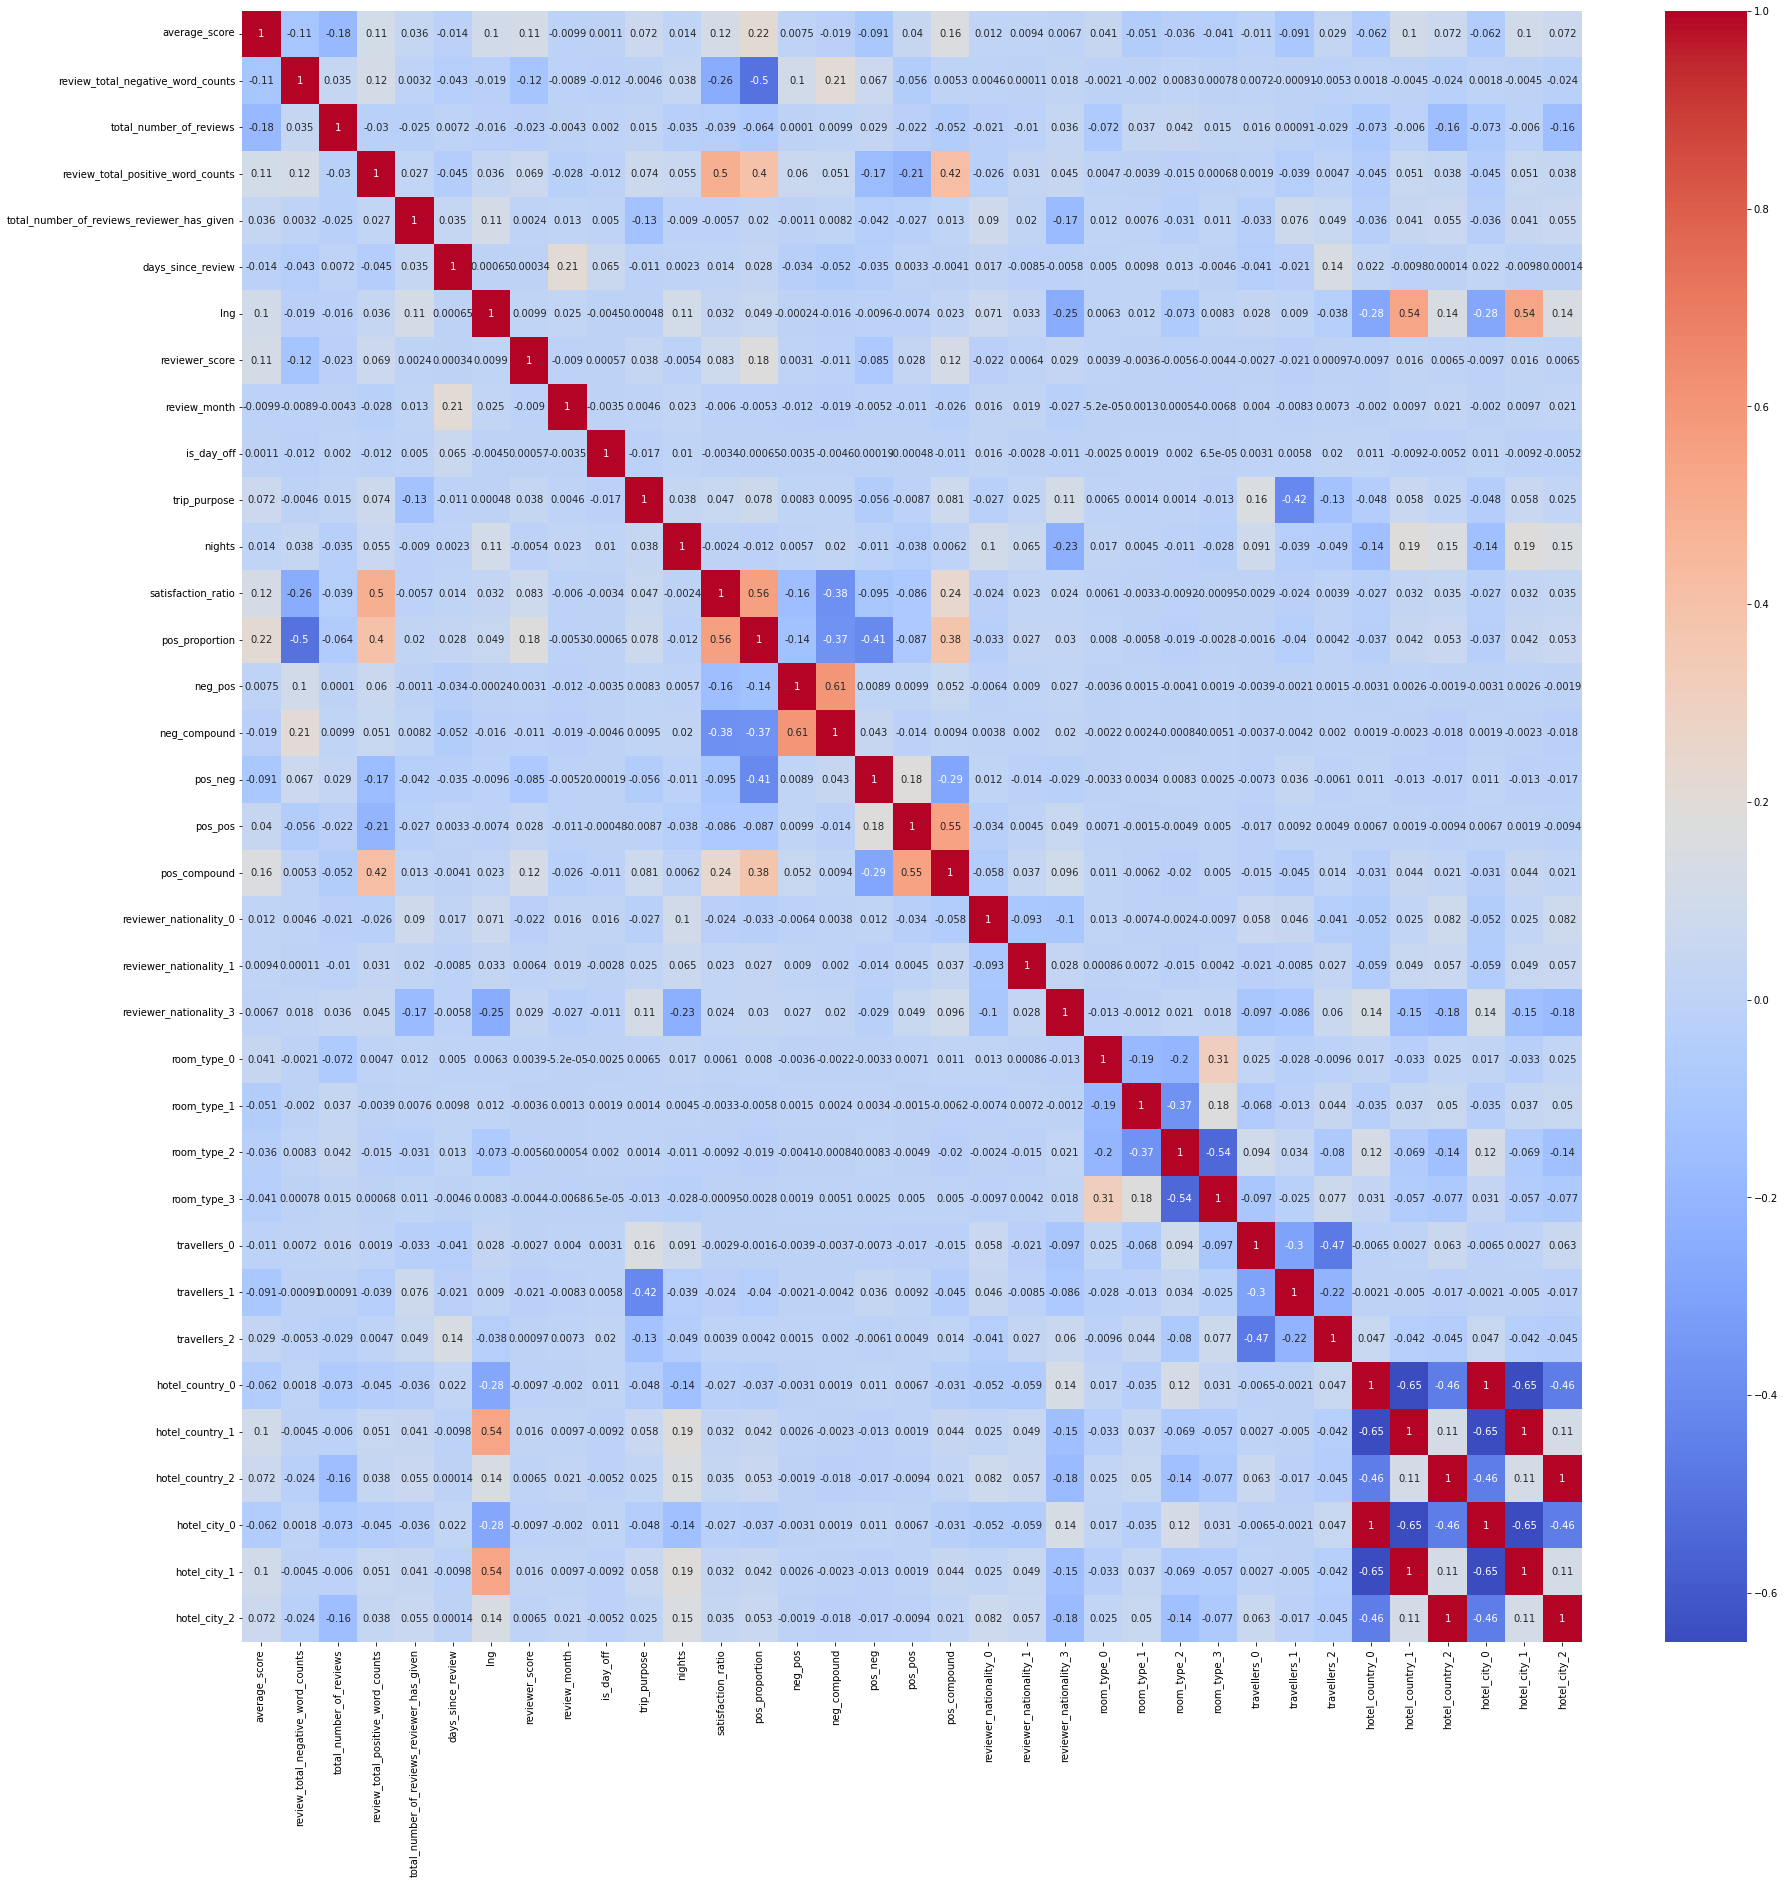

In [68]:
plt.rcParams['figure.figsize'] = (30,30)
sns.heatmap(hotels.drop(['sample'], axis=1).corr(), annot=True, cmap='coolwarm')

Очистим датасет от сильно коррелирующих признаков, на основании информации из матрицы корреляций.

In [66]:
hotels.drop(['neg_neu', 'pos_neu', 'neg_neg', 'additional_number_of_scoring', 'lat', 'reviewer_nationality_2'], axis = 1, inplace=True)

<AxesSubplot:>

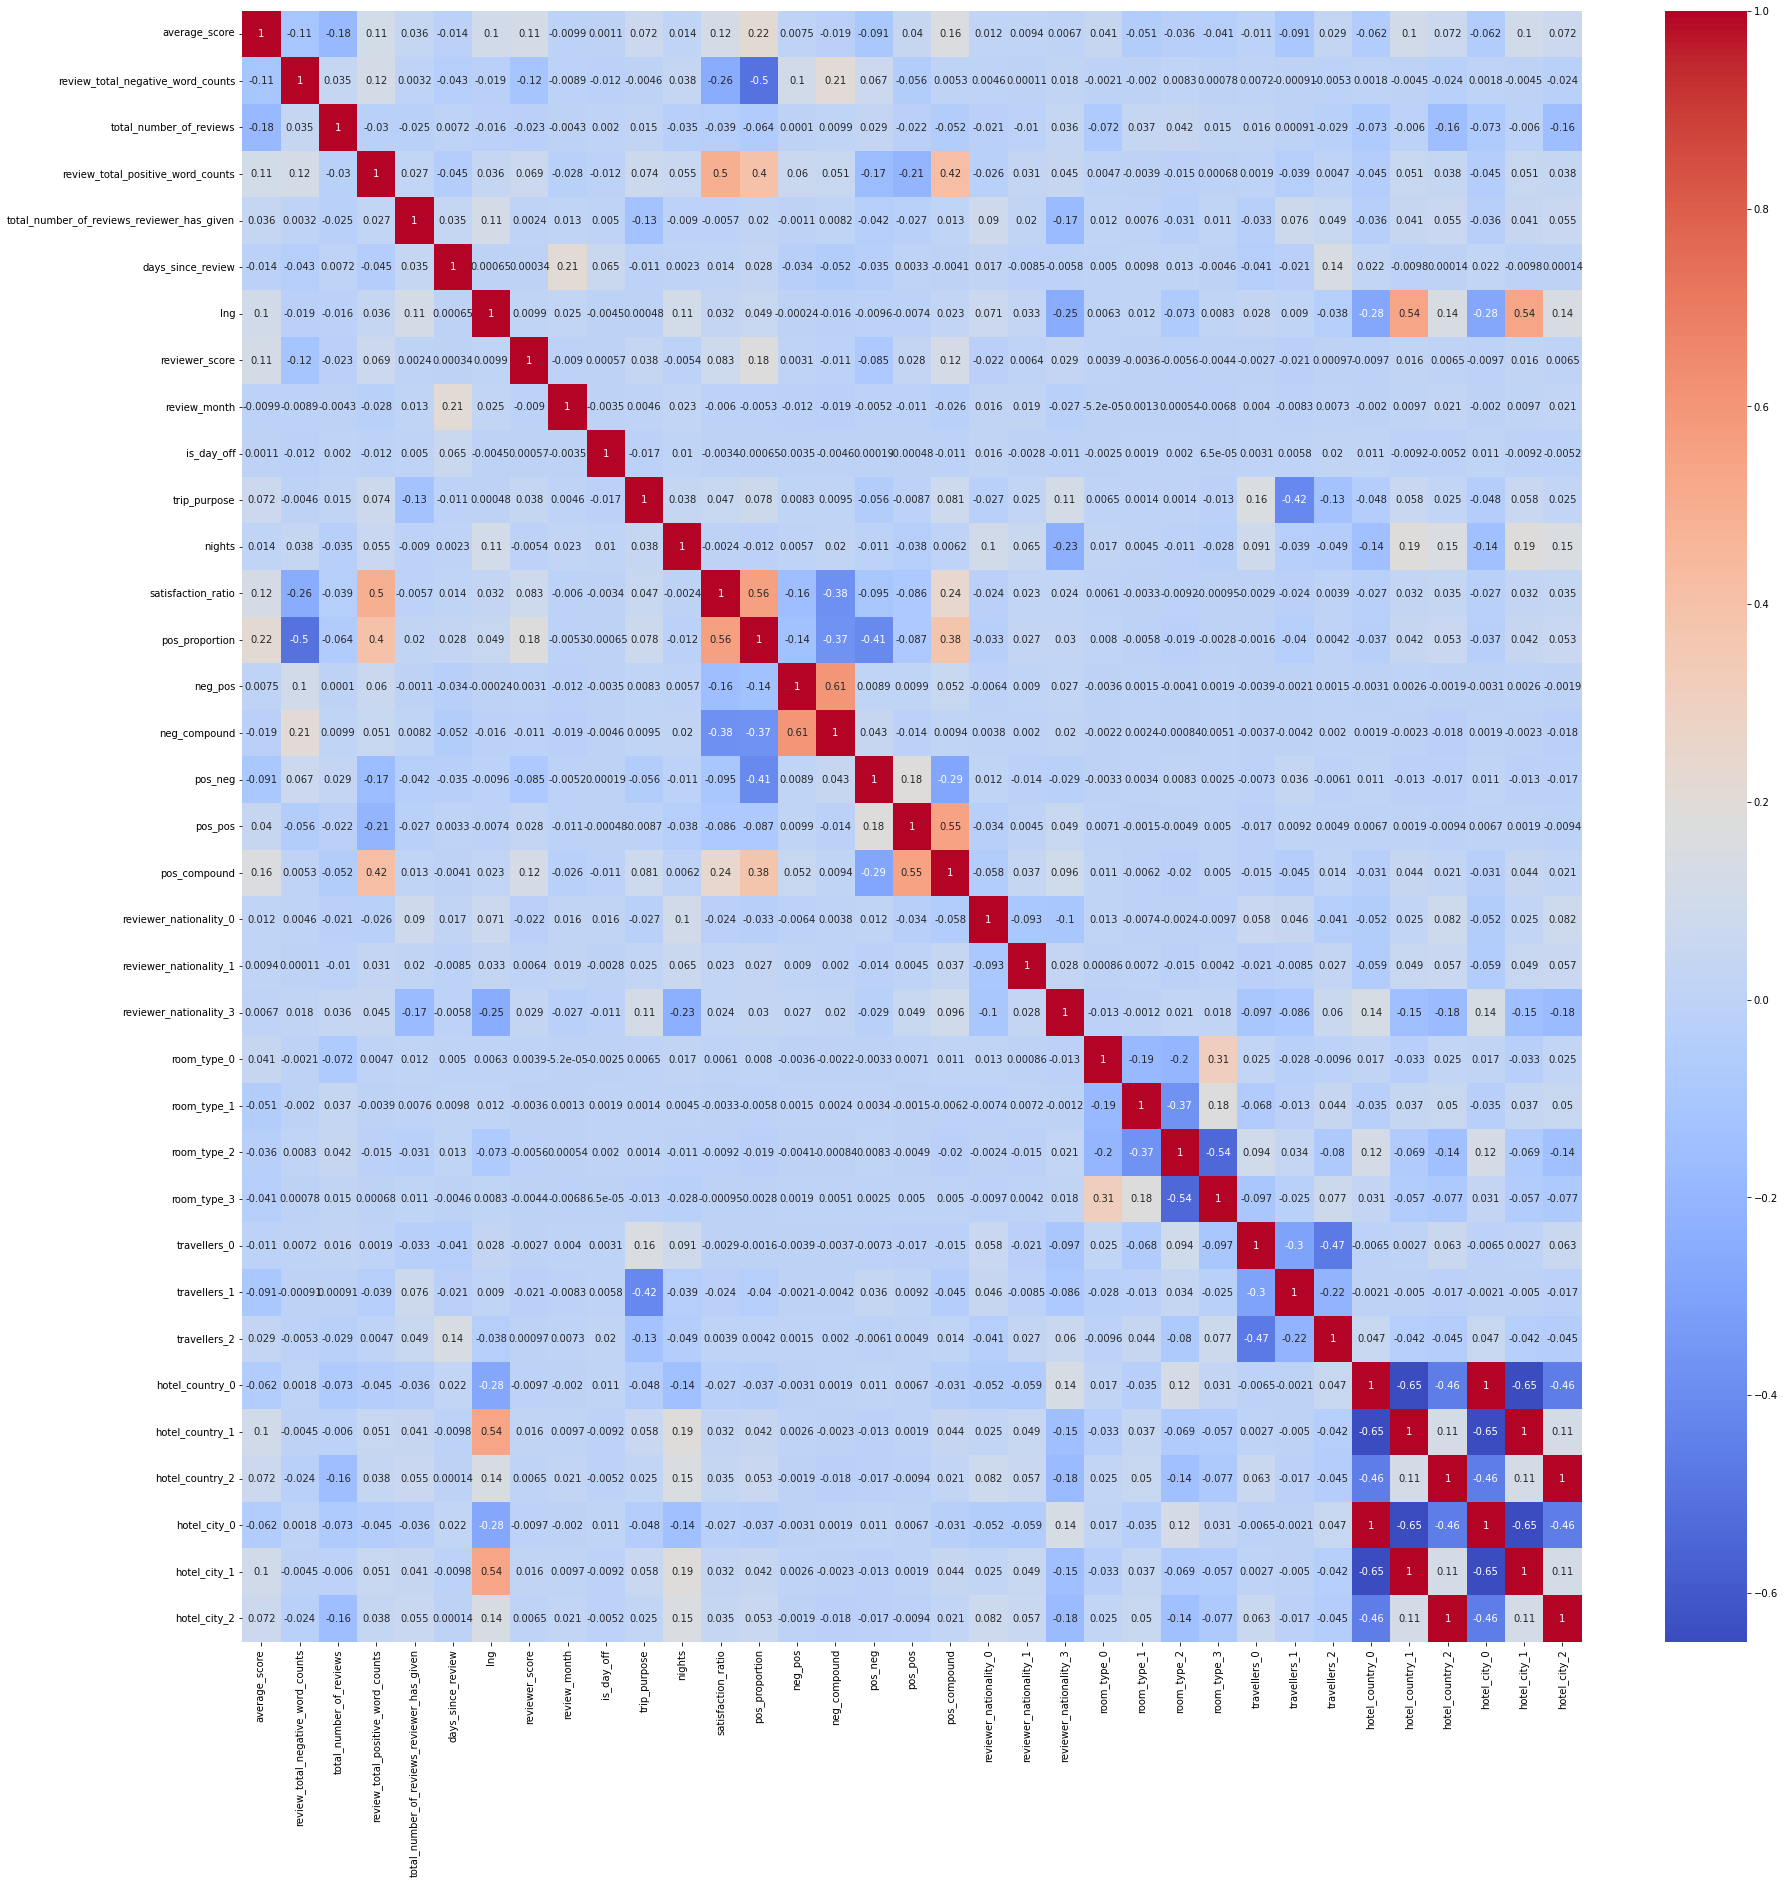

In [69]:
plt.rcParams['figure.figsize'] = (30,30)
sns.heatmap(hotels.drop(['sample'], axis=1).corr(), annot=True, cmap='coolwarm')

In [70]:
# непрерывные признаки
num_cols = [
     'average_score', 'review_total_negative_word_counts',
     'total_number_of_reviews', 
     'review_total_positive_word_counts', 
     'total_number_of_reviews_reviewer_has_given',
     'days_since_review', 'lng',
     'satisfaction_ratio', 'pos_proportion', 
     'neg_pos','neg_compound', 'pos_neg', 'pos_pos', 'pos_compound'
    
     ]

# категориальные признаки
cat_cols = ['review_month',
     'is_day_off',
     'trip_purpose', 'nights',
     'reviewer_nationality_0', 'reviewer_nationality_1',
     'reviewer_nationality_3','travellers_0', 
     'travellers_1', 'travellers_2','room_type_0', 
     'room_type_1', 'room_type_2', 'room_type_3',
     'hotel_country_0', 'hotel_country_1', 'hotel_country_2',
     'hotel_city_0', 'hotel_city_1', 'hotel_city_2'
     ]

In [71]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

X = train_data.drop(['reviewer_score'], axis=1)
y = train_data.reviewer_score.values

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

<AxesSubplot:>

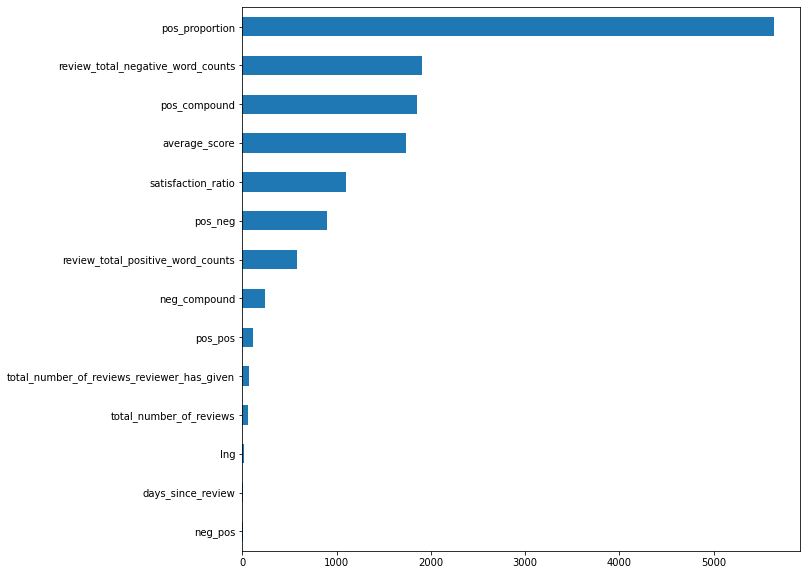

In [72]:
from sklearn.feature_selection import f_classif # anova

plt.rcParams['figure.figsize'] = (10,10)
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<AxesSubplot:>

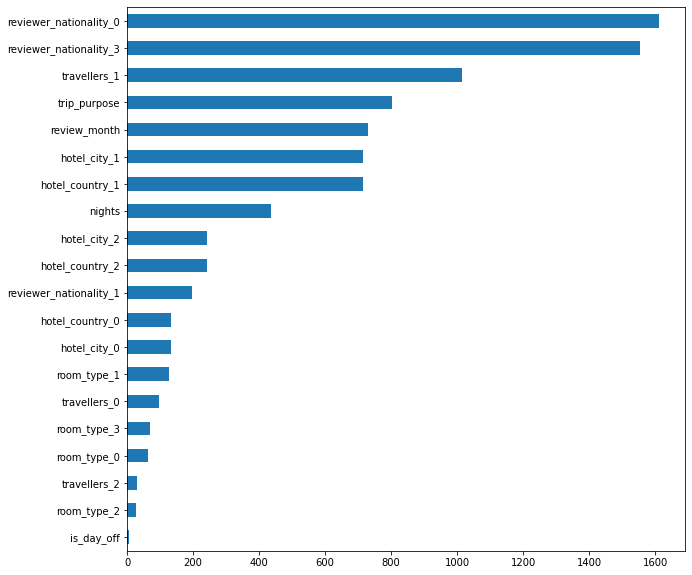

In [73]:
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

### Подготовка данных для модели

In [74]:
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

X = train_data.drop(['reviewer_score'], axis=1)
y = train_data.reviewer_score.values

In [76]:
# разделяем тренинговый датасет: 75% на обучение, 25% на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [77]:
# проверяем размерности получившихся датасетов
train_data.shape, test_data.shape, X.shape, X_train.shape, X_test.shape

((386803, 35), (128935, 35), (386803, 34), (290102, 34), (96701, 34))

In [78]:
# создаём модель
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=42)

# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train) 

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s


MAPE: 0.1255993180567953


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.2s finished


<AxesSubplot:>

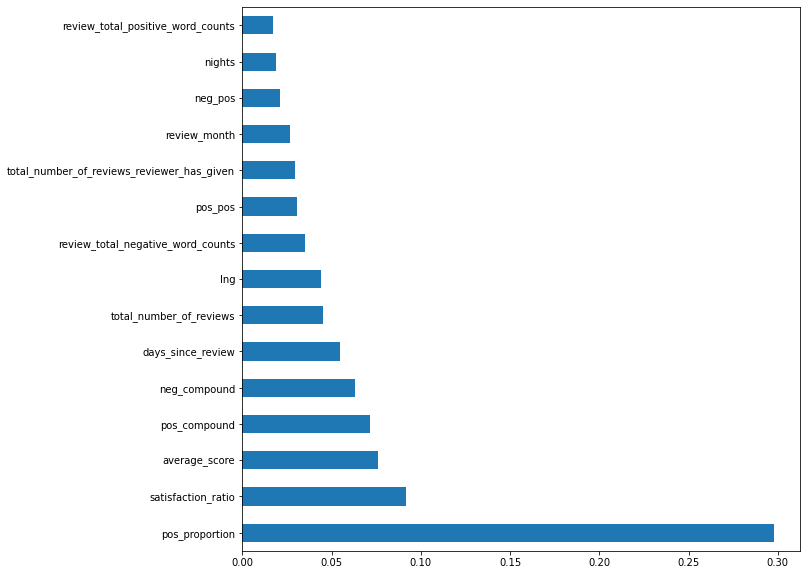

In [79]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

После оценки значимости непрерывных переменных мы получили очень низкую значимость таких признаков как lng, days_since_review и neg_pos. Однако эти признаки оказались одни из самых важных признаков для обучения модели.

In [81]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [82]:
predict_submission = regr.predict(test_data)
predict_submission

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.8s finished


array([8.509, 7.518, 7.877, ..., 8.163, 9.491, 6.943])

In [83]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('final_submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.509,488440
1,7.518,274649
2,7.877,374688
3,9.656,404352
4,9.576,451596
5,9.069,302161
6,7.839,317079
7,7.503,13963
8,8.693,159785
9,7.270,195089
